<a href="https://colab.research.google.com/github/sharlynmuturi/data-engineering-and-analytics-projects/blob/main/customer-product-sales-analytics-pipeline/scripts/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import sqlite3

In [41]:
# Creating database connection
conn = sqlite3.connect('/content/sales.db')

# Checking tables present in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
tables

,name
0,Products
1,Orders
2,Customers
3,Location


In [42]:
for table in tables['name']:
  print('-'*50, f'{table}', '-'*50)
  record_count = pd.read_sql(f"SELECT COUNT(*) AS count FROM {table};", conn)
  print('Count of records:', record_count['count'].values[0])
  display(pd.read_sql(f"SELECT * FROM {table} LIMIT 5;", conn))

-------------------------------------------------- Products --------------------------------------------------
Count of records: 1894


,Product ID,Category,Sub-Category,Product Name
0,FUR-BO-10000112,Furniture,Bookcases,"Bush Birmingham Collection Bookcase, Dark Cherry"
1,FUR-BO-10000330,Furniture,Bookcases,"Sauder Camden County Barrister Bookcase, Plank..."
2,FUR-BO-10000362,Furniture,Bookcases,Sauder Inglewood Library Bookcases
3,FUR-BO-10000468,Furniture,Bookcases,O'Sullivan 2-Shelf Heavy-Duty Bookcases
4,FUR-BO-10000711,Furniture,Bookcases,"Hon Metal Bookcases, Gray"


-------------------------------------------------- Orders --------------------------------------------------
Count of records: 10995


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,Product ID,Sales,Quantity,Discount,Profit
0,1,CA-2022-152156,08/11/2022,11/11/2022,Second Class,CG-12520,Consumer,42420.0,FUR-BO-10001798,261.9600,2.0,0.00,41.9136
1,2,CA-2022-152156,08/11/2022,11/11/2022,Second Class,CG-12520,Consumer,42420.0,FUR-CH-10000454,731.9400,3.0,0.00,219.5820
2,3,CA-2022-138688,12/06/2022,16/06/2022,Second Class,DV-13045,Corporate,90036.0,OFF-LA-10000240,14.6200,2.0,0.00,6.8714
3,4,US-2021-108966,11/10/2021,18/10/2021,Standard Class,SO-20335,Consumer,33311.0,FUR-TA-10000577,957.5775,5.0,0.45,-383.0310
4,5,US-2021-108966,11/10/2021,18/10/2021,Standard Class,SO-20335,Consumer,33311.0,OFF-ST-10000760,22.3680,2.0,0.20,2.5164


-------------------------------------------------- Customers --------------------------------------------------
Count of records: 793


,Customer ID,Customer Name
0,AA-10315,Alex Avila
1,AA-10375,Allen Armold
2,AA-10480,Andrew Allen
3,AA-10645,Anna Andreadi
4,AB-10015,Aaron Bergman


-------------------------------------------------- Location --------------------------------------------------
Count of records: 632


,Postal Code,City,State,Region,Country/Region
0,76106.0,Fort Worth,Texas,Central,United States
1,53711.0,Madison,Wisconsin,Central,United States
2,68025.0,Fremont,Nebraska,Central,United States
3,77095.0,Houston,Texas,Central,United States
4,75080.0,Richardson,Texas,Central,United States


## Combined summary of sales and profit per customer and product.

In [72]:
import time
start = time.time()
sales_summary = pd.read_sql_query("""
  SELECT
      o."Customer ID",
      c."Customer Name",
      p."Product ID",
      p."Product Name",
      p."Category",
      p."Sub-Category",
      SUM(o.Sales) AS total_sales,
      SUM(o.Profit) AS total_profit,
      COUNT(o."Order ID") AS total_orders
  FROM orders o
  JOIN customers c ON o."Customer ID" = c."Customer ID"
  JOIN products p ON o."Product ID" = p."Product ID"
  GROUP BY
      o."Customer ID",
      c."Customer Name",
      p."Product ID",
      p."Product Name",
      p."Category",
      p."Sub-Category"
  ORDER BY total_sales DESC;
""", conn)
end = time.time()
print('Time taken:', end-start)
sales_summary.head()

Time taken: 0.18266677856445312


,Customer ID,Customer Name,Product ID,Product Name,Category,Sub-Category,total_sales,total_profit,total_orders
0,SM-20320,Sean Miller,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480,-1811.0784,1
1,AB-10105,Adrian Barton,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,Binders,19785.480,9892.7400,2
2,TC-20980,Tamara Chand,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,17499.950,8399.9760,1
3,RB-19360,Raymond Buch,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,13999.960,6719.9808,1
4,TA-21385,Tom Ashbrook,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,11199.968,3919.9888,1


In [87]:
# Optimized query using a CTE

import time
start = time.time()
sales_summary = pd.read_sql_query("""
  WITH agg_orders AS (
      SELECT
          "Customer ID",
          "Product ID",
          SUM(Sales) AS total_sales,
          SUM(Profit) AS total_profit,
          COUNT("Order ID") AS total_orders
      FROM orders
      GROUP BY "Customer ID", "Product ID"
  )
  SELECT
      ao."Customer ID",
      c."Customer Name",
      ao."Product ID",
      p."Product Name",
      p."Category",
      p."Sub-Category",
      ao.total_sales,
      ao.total_profit,
      ao.total_orders
  FROM agg_orders ao
  JOIN customers c ON ao."Customer ID" = c."Customer ID"
  JOIN products p ON ao."Product ID" = p."Product ID"
  ORDER BY ao.total_sales DESC;
  """, conn)
end = time.time()
print('Time taken:', end-start)

Time taken: 0.1502974033355713


In [88]:
sales_summary.head()

,Customer ID,Customer Name,Product ID,Product Name,Category,Sub-Category,total_sales,total_profit,total_orders
0,SM-20320,Sean Miller,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480,-1811.0784,1
1,AB-10105,Adrian Barton,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,Binders,19785.480,9892.7400,2
2,TC-20980,Tamara Chand,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,17499.950,8399.9760,1
3,RB-19360,Raymond Buch,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,13999.960,6719.9808,1
4,TA-21385,Tom Ashbrook,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,11199.968,3919.9888,1


# Data Analysis and Transformation

In [75]:
sales_summary.isnull().sum()

,0
Customer ID,0
Customer Name,0
Product ID,0
Product Name,0
Category,0
Sub-Category,0
total_sales,0
total_profit,0
total_orders,0


In [74]:
sales_summary.dtypes

,0
Customer ID,object
Customer Name,object
Product ID,object
Product Name,object
Category,object
Sub-Category,object
total_sales,float64
total_profit,float64
total_orders,int64


In [91]:
# High-Value Customer Flag (top 10% by total_sales)
threshold = sales_summary['total_sales'].quantile(0.9)
sales_summary['high_value_customer'] = sales_summary['total_sales'] > threshold

In [93]:
# Profit Margin per customer-product
sales_summary['profit_margin'] = sales_summary['total_profit'] / sales_summary['total_sales']

In [94]:
# High-Profit Product Flag
sales_summary['high_profit_product'] = sales_summary['profit_margin'] > 0.5

In [95]:
# Average Order Value
sales_summary['avg_order_value'] = sales_summary['total_sales'] / sales_summary['total_orders']

In [96]:
# Rank products per customer by sales
sales_summary['product_rank_per_customer'] = sales_summary.groupby('Customer ID')['total_sales'].rank(method='dense', ascending=False)

In [97]:
# Sales to Profit Ratio
sales_summary['sales_to_profit_ratio'] = sales_summary['total_sales'] / sales_summary['total_profit']

In [98]:
# Category Metrics
category_agg = (sales_summary.groupby(['Category', 'Sub-Category']).agg({'total_sales':'sum', 'total_profit':'sum'}).reset_index())
category_agg['category_sales_pct'] = category_agg['total_sales'] / category_agg['total_sales'].sum()
category_agg['category_profit_ratio'] = category_agg['total_profit'] / category_agg['total_sales']

sales_summary = sales_summary.merge(category_agg[['Category','Sub-Category','category_sales_pct','category_profit_ratio']],
                                      on=['Category','Sub-Category'], how='left')

In [99]:
print(sales_summary.head())


  Customer ID  Customer Name       Product ID  \
0    SM-20320    Sean Miller  TEC-MA-10002412   
1    AB-10105  Adrian Barton  OFF-BI-10000545   
2    TC-20980   Tamara Chand  TEC-CO-10004722   
3    RB-19360   Raymond Buch  TEC-CO-10004722   
4    TA-21385   Tom Ashbrook  TEC-CO-10004722   

                                        Product Name         Category  \
0  Cisco TelePresence System EX90 Videoconferenci...       Technology   
1   GBC Ibimaster 500 Manual ProClick Binding System  Office Supplies   
2              Canon imageCLASS 2200 Advanced Copier       Technology   
3              Canon imageCLASS 2200 Advanced Copier       Technology   
4              Canon imageCLASS 2200 Advanced Copier       Technology   

  Sub-Category  total_sales  total_profit  total_orders  high_value_customer  \
0     Machines    22638.480    -1811.0784             1                 True   
1      Binders    19785.480     9892.7400             2                 True   
2      Copiers    17499.95

In [101]:
sales_summary.dtypes

,0
Customer ID,object
Customer Name,object
Product ID,object
Product Name,object
Category,object
Sub-Category,object
total_sales,float64
total_profit,float64
total_orders,int64
high_value_customer,bool


# Table to store the final analytics-ready dataset.

In [102]:
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS sales_summary;")

cursor.execute("""
CREATE TABLE sales_summary (
    customer_id TEXT,
    customer_name TEXT,
    product_id TEXT,
    product_name TEXT,
    category TEXT,
    sub_category TEXT,
    total_sales FLOAT,
    total_profit FLOAT,
    total_orders INT,
    high_value_customer BOOLEAN,
    profit_margin FLOAT,
    high_profit_product BOOLEAN,
    avg_order_value FLOAT,
    product_rank_per_customer FLOAT,
    sales_to_profit_ratio FLOAT,
    category_sales_pct FLOAT,
    category_profit_ratio FLOAT
);
""")
conn.commit()
print("Table sales_summary created successfully!")


Table sales_summary created successfully!


In [103]:
pd.read_sql_query("SELECT * FROM sales_summary;", conn)

,customer_id,customer_name,product_id,product_name,category,sub_category,total_sales,total_profit,total_orders,high_value_customer,profit_margin,high_profit_product,avg_order_value,product_rank_per_customer,sales_to_profit_ratio,category_sales_pct,category_profit_ratio


In [104]:
# Inserting data into the table
sales_summary.to_sql('sales_summary', conn, if_exists='replace', index=False)

10275

In [105]:
pd.read_sql_query("SELECT * FROM sales_summary;", conn)

,Customer ID,Customer Name,Product ID,Product Name,Category,Sub-Category,total_sales,total_profit,total_orders,high_value_customer,profit_margin,high_profit_product,avg_order_value,product_rank_per_customer,sales_to_profit_ratio,category_sales_pct,category_profit_ratio
0,SM-20320,Sean Miller,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480,-1811.0784,1,1,-0.08,0,22638.480,1.0,-12.500000,0.076337,0.014709
1,AB-10105,Adrian Barton,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,Binders,19785.480,9892.7400,2,1,0.50,0,9892.740,1.0,2.000000,0.094414,0.149668
2,TC-20980,Tamara Chand,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,17499.950,8399.9760,1,1,0.48,0,17499.950,1.0,2.083333,0.058523,0.369531
3,RB-19360,Raymond Buch,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,13999.960,6719.9808,1,1,0.48,0,13999.960,1.0,2.083333,0.058523,0.369531
4,TA-21385,Tom Ashbrook,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,11199.968,3919.9888,1,1,0.35,0,11199.968,1.0,2.857143,0.058523,0.369531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270,CM-12715,Craig Molinari,OFF-BI-10004140,Avery Non-Stick Binders,Office Supplies,Binders,0.898,-1.5715,1,0,-1.75,0,0.898,13.0,-0.571429,0.094414,0.149668
10271,HG-14965,Henry Goldwyn,OFF-BI-10003460,Acco 3-Hole Punch,Office Supplies,Binders,0.876,-1.4016,1,0,-1.60,0,0.876,17.0,-0.625000,0.094414,0.149668
10272,JO-15280,Jas O'Carroll,OFF-BI-10003529,Avery Round Ring Poly Binders,Office Supplies,Binders,0.852,-0.5964,1,0,-0.70,0,0.852,11.0,-1.428571,0.094414,0.149668
10273,KB-16600,Ken Brennan,OFF-BI-10003727,Avery Durable Slant Ring Binders With Label Ho...,Office Supplies,Binders,0.836,-1.3376,1,0,-1.60,0,0.836,9.0,-0.625000,0.094414,0.149668


# Performance Analysis on final dataset.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import stats

import warnings
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_sql_query('SELECT * FROM sales_summary', conn)
df.head()

,Customer ID,Customer Name,Product ID,Product Name,Category,Sub-Category,total_sales,total_profit,total_orders,high_value_customer,profit_margin,high_profit_product,avg_order_value,product_rank_per_customer,sales_to_profit_ratio,category_sales_pct,category_profit_ratio
0,SM-20320,Sean Miller,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480,-1811.0784,1,1,-0.08,0,22638.480,1.0,-12.500000,0.076337,0.014709
1,AB-10105,Adrian Barton,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,Binders,19785.480,9892.7400,2,1,0.50,0,9892.740,1.0,2.000000,0.094414,0.149668
2,TC-20980,Tamara Chand,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,17499.950,8399.9760,1,1,0.48,0,17499.950,1.0,2.083333,0.058523,0.369531
3,RB-19360,Raymond Buch,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,13999.960,6719.9808,1,1,0.48,0,13999.960,1.0,2.083333,0.058523,0.369531
4,TA-21385,Tom Ashbrook,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,11199.968,3919.9888,1,1,0.35,0,11199.968,1.0,2.857143,0.058523,0.369531


### Summary Statistics

In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_sales,10275.0,255.618034,698.660549,0.444000,18.755000,59.980000,230.548000,2.263848e+04
total_profit,10275.0,31.904590,265.457206,-7403.785600,1.864200,9.331200,32.537600,9.892740e+03
total_orders,10275.0,1.106180,0.311851,1.000000,1.000000,1.000000,1.000000,4.000000e+00
high_value_customer,10275.0,0.100049,0.300079,0.000000,0.000000,0.000000,0.000000,1.000000e+00
profit_margin,10275.0,0.122160,0.464373,-2.750000,0.075000,0.270000,0.362500,5.000000e-01
high_profit_product,10275.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
avg_order_value,10275.0,231.980689,621.715577,0.444000,17.480000,55.470000,211.247000,2.263848e+04
product_rank_per_customer,10275.0,8.237956,5.830261,1.000000,4.000000,7.000000,12.000000,3.600000e+01
sales_to_profit_ratio,10275.0,inf,NaN,-90.000000,2.083333,2.857143,4.000000,inf
category_sales_pct,10275.0,0.068374,0.044258,0.001231,0.035422,0.076337,0.094414,1.488526e-01


### Customer-Level Performance



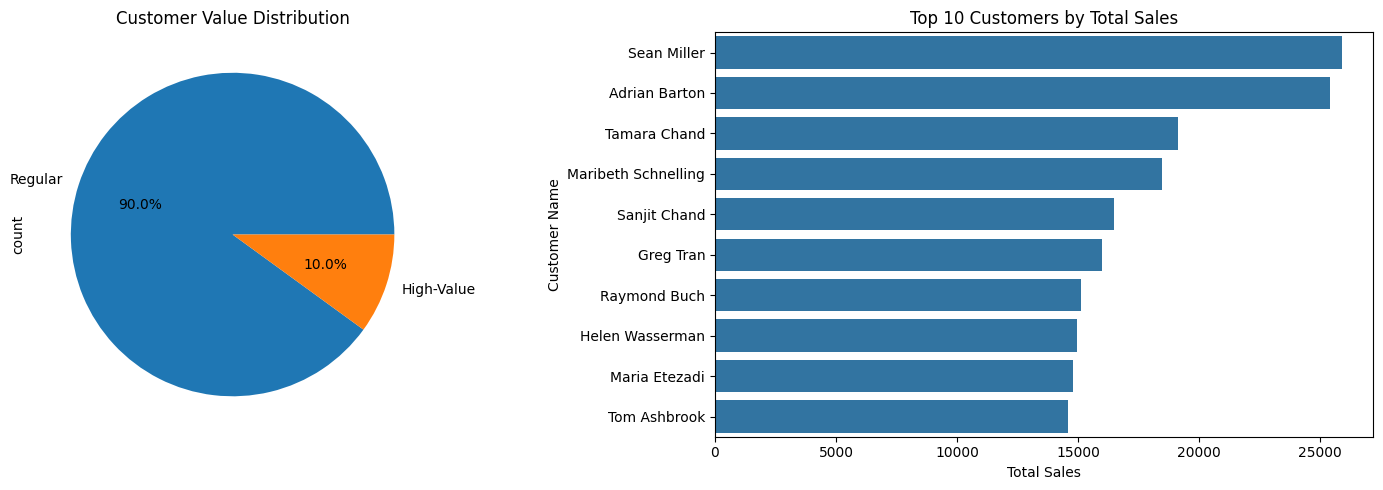

In [138]:
plt.figure(figsize=(15, 5))

# Plot for High Value vs Regular Customers
plt.subplot(1, 2, 1)

sales_summary['high_value_customer'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Regular','High-Value'])
plt.title("Customer Value Distribution")

# Plot for Top Customers by sales
plt.subplot(1, 2, 2)

top_customers = sales_summary.groupby('Customer Name')['total_sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_customers.values, y=top_customers.index)
plt.title("Top 10 Customers by Total Sales")
plt.xlabel("Total Sales")

plt.tight_layout()
plt.show()


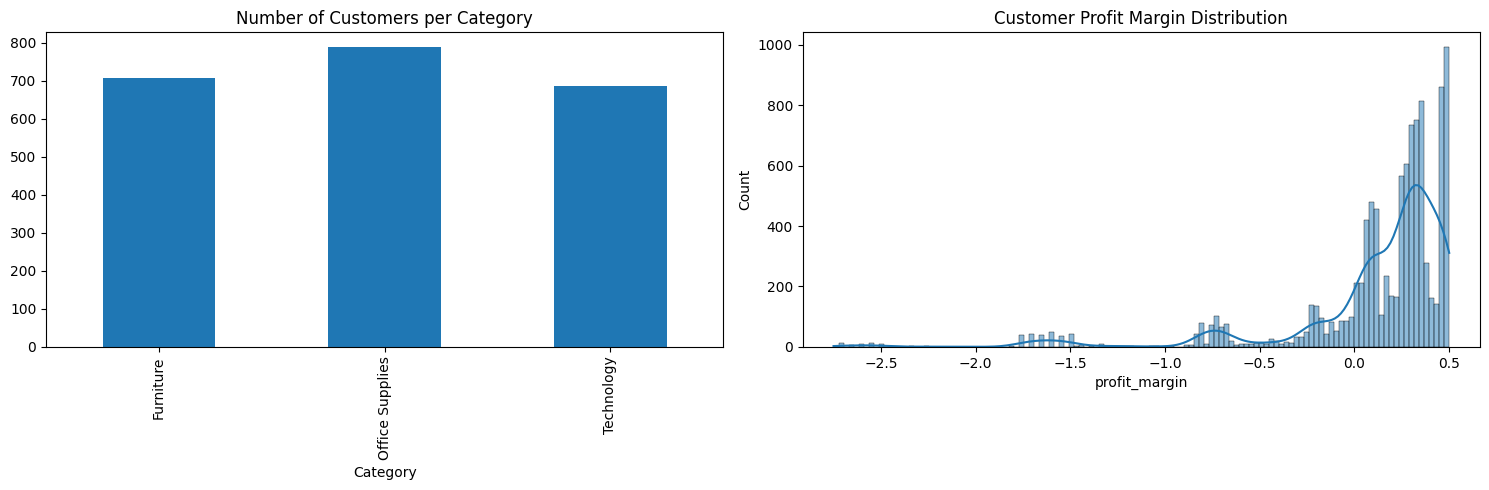

In [140]:
plt.figure(figsize=(15, 5))

# Plot for Number of Customers per Category
plt.subplot(1, 2, 1)

cust_per_category = sales_summary.groupby('Category')['Customer ID'].nunique()
cust_per_category.plot(kind='bar')
plt.title("Number of Customers per Product Category")

# Plot for Customer Profit Margin Distribution
plt.subplot(1, 2, 2)

sns.histplot(sales_summary['profit_margin'], kde=True)
plt.title("Customer Profit Margin Distribution")

plt.tight_layout()
plt.show()

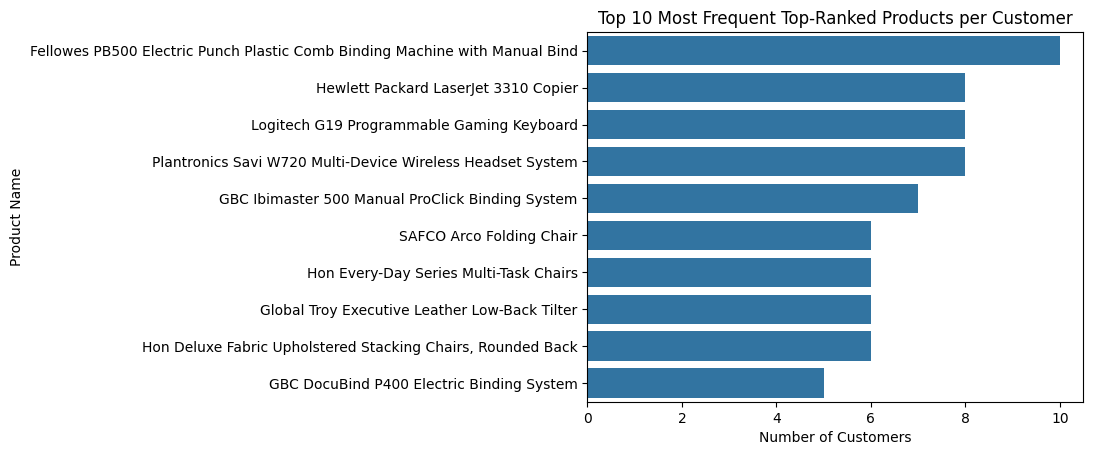

In [135]:
# How many customers rank each product as their top purchase.

# Filter top-ranked products per customer, top 10 most frequent products
top_products_customer = sales_summary[sales_summary['product_rank_per_customer'] == 1]
top_10_products = top_products_customer['Product Name'].value_counts().head(10).index

sns.countplot(
    y='Product Name',
    data=top_products_customer,
    order=top_10_products
)
plt.title("Top 10 Most Frequent Top-Ranked Products per Customer")
plt.xlabel("Number of Customers")
plt.ylabel("Product Name")
plt.show()


### Product-Level Performance

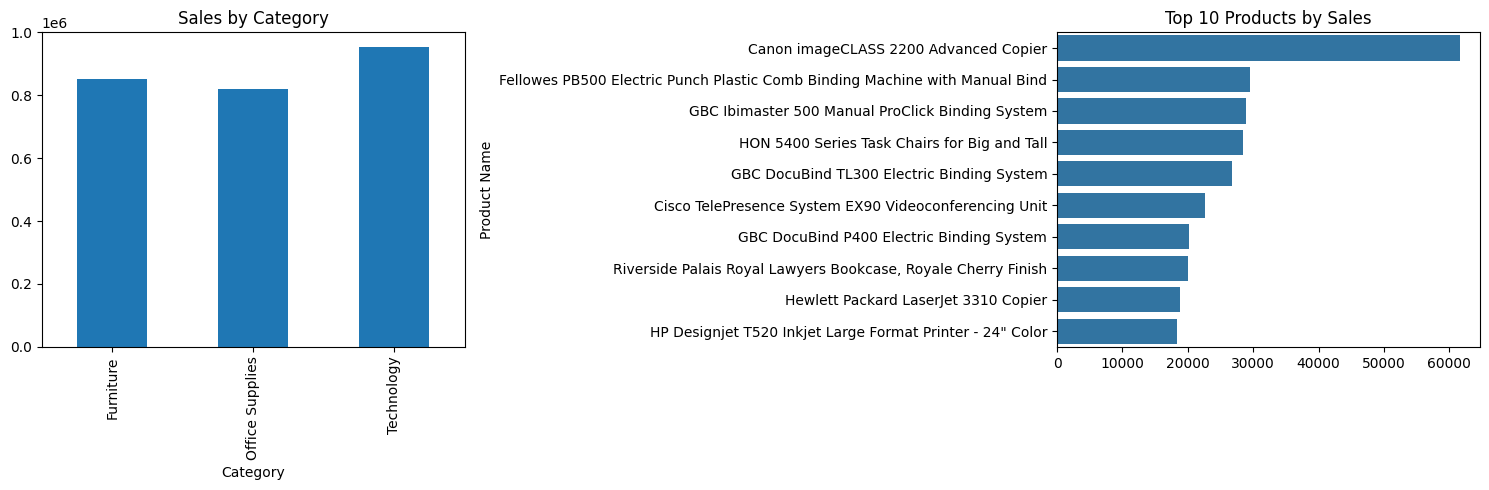

In [139]:
plt.figure(figsize=(15, 5))

# Plot for sales per category
plt.subplot(1, 2, 1)

category_sales = sales_summary.groupby('Category')['total_sales'].sum()
category_sales.plot(kind='bar')
plt.title("Sales by Category")

# Plot for Top Products by sales
plt.subplot(1, 2, 2)

top_products = sales_summary.groupby('Product Name')['total_sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Products by Sales")

plt.tight_layout()
plt.show()

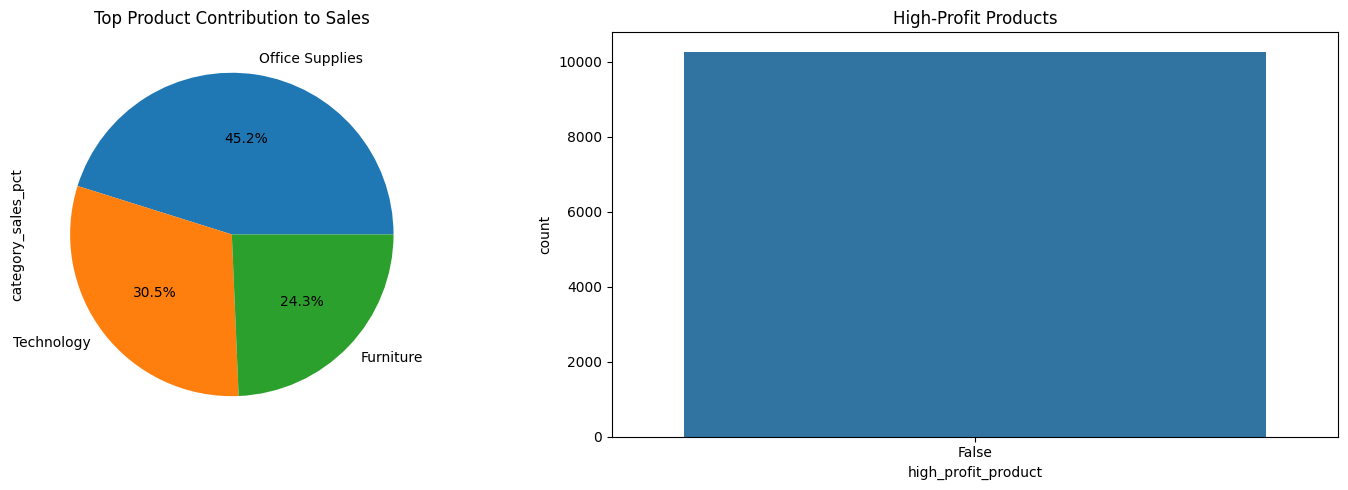

In [141]:
plt.figure(figsize=(15, 5))

# Plot for Top Product Contribution to Sales
plt.subplot(1, 2, 1)

top_products_pct = sales_summary.groupby('Category')['category_sales_pct'].sum().sort_values(ascending=False).head(10)
top_products_pct.plot(kind='pie', autopct='%1.1f%%')
plt.title("Top Product Contribution to Sales")

# Plot for Count of High-Profit Products
plt.subplot(1, 2, 2)

sns.countplot(x='high_profit_product', data=sales_summary)
plt.title("High-Profit Products")

plt.tight_layout()
plt.show()

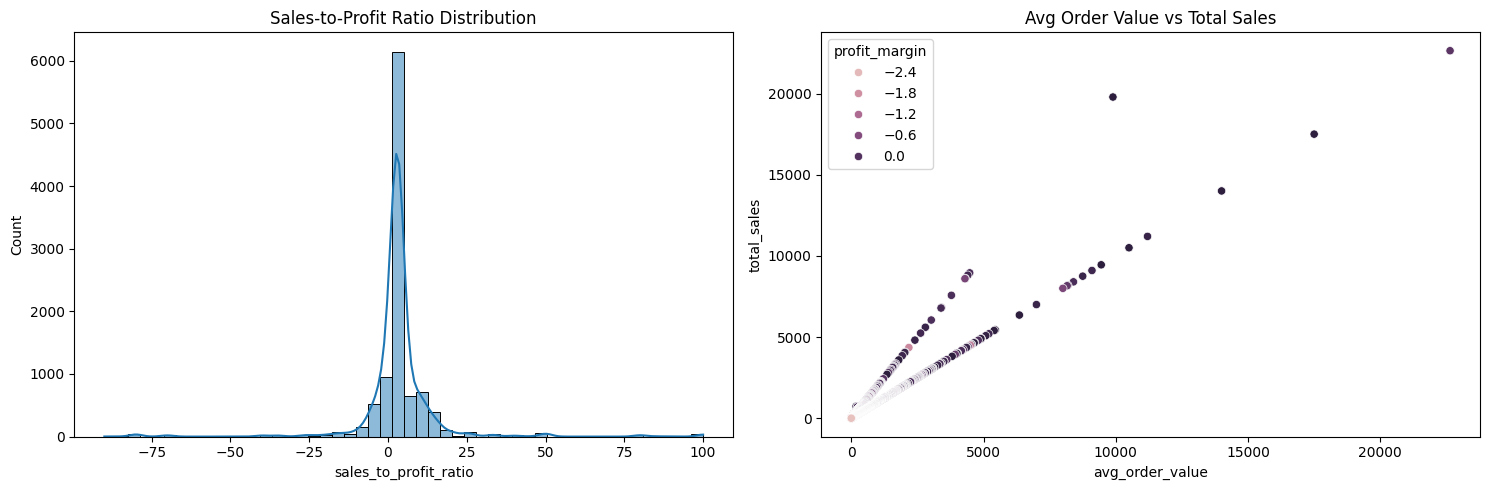

In [143]:
plt.figure(figsize=(15, 5))

# Plot for Sales-to-Profit Ratio Distribution
plt.subplot(1, 2, 1)

sns.histplot(sales_summary['sales_to_profit_ratio'], bins=50, kde=True)
plt.title("Sales-to-Profit Ratio Distribution")

# Plot for Average Order Value vs Total Sales
plt.subplot(1, 2, 2)

sns.scatterplot(data=sales_summary, x='avg_order_value', y='total_sales', hue='profit_margin')
plt.title("Avg Order Value vs Total Sales")

plt.tight_layout()
plt.show()